Using device: cuda
Generating Test Data...
Samples    | Avg Test MSE   
----------------------------
100        | 0.0002627
500        | 0.0002167
1000       | 0.0002107
2500       | 0.0002105
5000       | 0.0002097

Total Runtime: 1.77 minutes


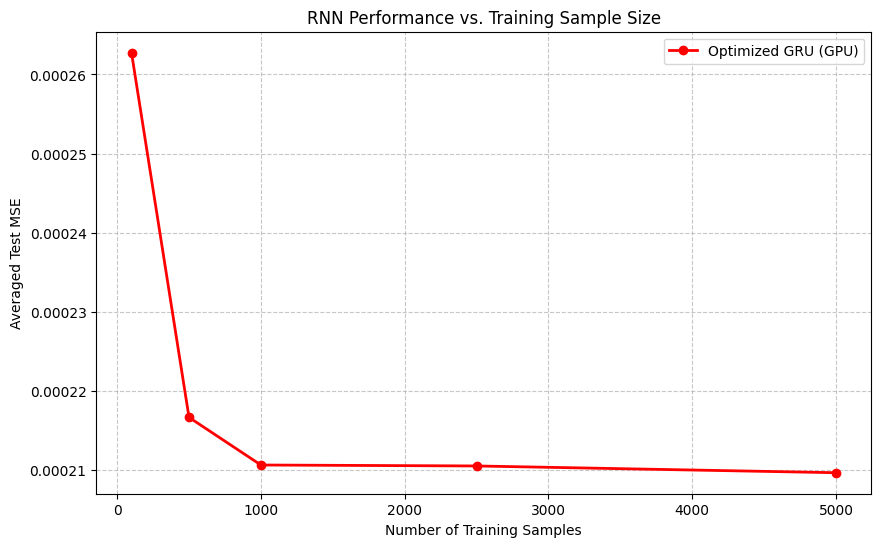

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Check for GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


TRIALS_PER_N = 3
EPOCHS = 100
BATCH_SIZE = 64
WINDOW_SIZE = 10
LEARNING_RATE = 0.01

def generate_ar_data(n_samples, coeffs=[0.5, -0.25, 0.1, -0.2]):
    X = np.zeros(n_samples + 100)
    U = np.random.uniform(0, 0.05, n_samples + 100)
    for t in range(4, len(X)):
        X[t] = (coeffs[0]*X[t-1] + coeffs[1]*X[t-2] +
                coeffs[2]*X[t-3] + coeffs[3]*X[t-4] + U[t])
    return torch.FloatTensor(X[100:]).view(-1, 1)

def create_sequences(data, window_size):
    X_seq, y_label = [], []
    for i in range(len(data) - window_size):
        X_seq.append(data[i:i + window_size])
        y_label.append(data[i + window_size])
    return torch.stack(X_seq), torch.stack(y_label)

# --- 2. RNN Model ---
class ARPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super(ARPredictor, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, h_n = self.rnn(x)
        return self.fc(h_n.squeeze(0))

# --- 3. Training Function ---
def train_and_evaluate(train_size, test_X, test_y):
    # Data Generation
    train_raw = generate_ar_data(train_size)
    X_train, y_train = create_sequences(train_raw, WINDOW_SIZE)

    # Move Data to GPU immediately
    X_train, y_train = X_train.to(device), y_train.to(device)

    dataset = data.TensorDataset(X_train, y_train)
    loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Move Model to GPU
    model = ARPredictor().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

    model.train()
    for epoch in range(EPOCHS):
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
        scheduler.step()

    model.eval()
    with torch.no_grad():
        test_pred = model(test_X)
        test_mse = criterion(test_pred, test_y).item()

    return test_mse

sample_sizes = [100, 500, 1000, 2500, 5000]
avg_mse_results = []

print("Generating Test Data...")
test_raw = generate_ar_data(2000)
X_test, y_test = create_sequences(test_raw, WINDOW_SIZE)
# Move Test Data to GPU
X_test, y_test = X_test.to(device), y_test.to(device)

print(f"{'Samples':<10} | {'Avg Test MSE':<15}")
print("-" * 28)

start_time = time.time()

for N in sample_sizes:
    trial_mses = []
    for trial in range(TRIALS_PER_N):
        mse = train_and_evaluate(N, X_test, y_test)
        trial_mses.append(mse)

    avg_mse = np.mean(trial_mses)
    avg_mse_results.append(avg_mse)
    print(f"{N:<10} | {avg_mse:.7f}")

print(f"\nTotal Runtime: {(time.time() - start_time)/60:.2f} minutes")

plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, avg_mse_results, marker='o', color='red', linewidth=2, label='Optimized GRU (GPU)')
plt.title('RNN Performance vs. Training Sample Size')
plt.xlabel('Number of Training Samples')
plt.ylabel('Averaged Test MSE')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()